In [1]:
import rmtchem 
import timeit
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.integrate import solve_bvp
from scipy.signal import argrelmax,find_peaks,argrelmin
import imp
import cantera as ct
imp.reload(rmtchem)
from scipy.sparse import csr_matrix
plt.rcParams.update({'font.size': 12, 'pdf.fonttype':42,'text.usetex': False, 'font.family': 'serif'})
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

## Generate input files for XPPAUTO and and matcont benchmarks

[0]
0.278000	1.000000e-01	279	
Hopf bifurcation!		27.900000
0.345000	1.000000e-01	346	
Hopf bifurcation!		34.600000
0.492000	1.000000e-01	493	
Hopf bifurcation!		49.300000
1001 1 1.12509806900197871	


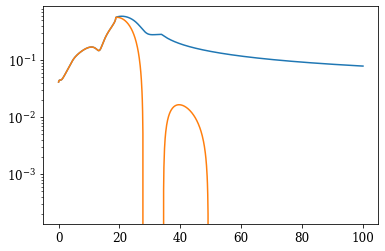

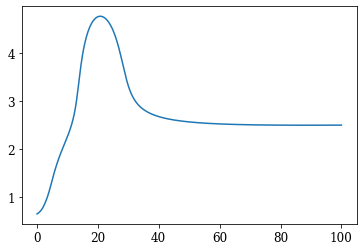

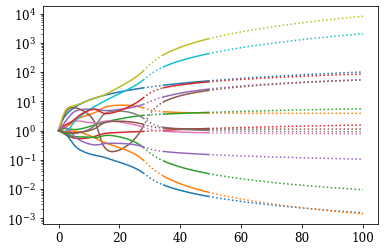

In [144]:
imp.reload(rmtchem)
n=8
nr=int(1.0*n*np.log(n))
nd=int(0.2*n)
na=int(0.5*nr)
seed=287

n=16
nr=int(0.5*n*np.log(n))
nd=int(0.1*n)
na=int(0.0*nr)
seed=134
seed=3
np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr,na) 
row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_matrix(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]
d0=1e6
d1min=0
d1max=100
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
X0=np.exp(-G)
print(inds)

r=np.linalg.matrix_rank(adj.toarray()[np.ix_(lcc,lcc)])
if(r==n):
    start=timeit.default_timer()
    Xs,epsilons,evals,bif=rmtchem.quasistatic(X0, eta, nu, k, XD1, XD2, d1min,d1max,d1min,dep0=1e-1,depmax=1e-1,depmin=1e-8,output=2, stop=False)
    stop=timeit.default_timer()
    print(len(Xs),bif,stop-start)

    file=open('rmtchem.ode','w')
    for i in range(n):
        if i in inds:
            print('X[%i]\'=(ep*D[%i]-E[%i]*exp(X[%i])'%(i,i,i,i),end='',file=file)
        else:
            print('X[%i]\'=(0'%(i),end='',file=file)
        for j in range(2*nr):
            if((eta[j,i]-nu[j,i])!=0):
                print('+(%i)*%f'%(eta[j,i]-nu[j,i],k[j]),end='',file=file)
                inds2=np.where(nu[j]>0)[0]
                for l in inds2:
                    print('*exp(X[%i])^(%i)'%(l,nu[j,l]),end='',file=file)
        print(')/exp(X[%i])\n'%(i),end='',file=file)

    for i in range(n):
        print('init X[%i]=%f'%(i,-G[i]),file=file)

    print('par ep=1',file=file)
    for i in range(n):
        if i in inds:
            print('par D[%i]=%f'%(i,XD1[i]),file=file)    
            print('par E[%i]=%f'%(i,XD2[i]),file=file)

    print('@ XP=T,YP=X0,XLO=0,XHI=1000,YLO=0,YHI=10',file=file)
    print('@ meth=cvode,dt=0.01,total=1000,nout=1000',file=file)
    print('@ NTST=100, NMAX=1000000, NPR=0, DSMIN=1e-6, DSMAX=1e-1, DS=1e-3, PARMIN=1.0, PARMAX=100',file=file)
    print('@ EPSU=1e-6, EPSL=1e-6, EPSS=1e-6',file=file)
    ind=np.setdiff1d(np.arange(n),inds)[0]
    print('@ NORMMAX=1e10, AUTOXMIN=0.0, AUTOXMAX=%f, AUTOYMIN=0, AUTOYMAX=%f, AUTOVAR=X%i'%(np.max(epsilons),np.max(Xs[:,ind]),ind),file=file)
    print('@ runnow=1, bound=100000',file=file)
    print('done',file=file)

    file.close()
    
plt.yscale('log')
plt.plot(epsilons,np.min(np.abs(evals),axis=1))
plt.plot(epsilons,-np.max(np.real(evals),axis=1))
plt.show()
plt.plot(epsilons,Xs[:,ind])
plt.show()
    
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i]/np.exp(-G[i]),color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i]/np.exp(-G[i]),ls=':',color=colors[np.mod(i,len(colors))])
plt.show()

In [ ]:
n=16
nr=int(0.5*n*np.log(n))
nd=int(0.1*n)
na=int(0.0*nr)
seed=134
seed=3
np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr,na) 
row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_matrix(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]
d0=1e6
d1min=0
d1max=100
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
X0=np.exp(-G)
print(inds)

r=np.linalg.matrix_rank(adj.toarray()[np.ix_(lcc,lcc)])
if(r==n):

    Xs,epsilons,evals,bif=rmtchem.quasistatic(X0, eta, nu, k, XD1, XD2, d1min,d1max,d1min,dep0=1e-1,depmin=1e-8,output=2, stop=False)
    print(len(Xs),bif)

    file=open('rmtchem2.ode','w')
    print('X0',file=file,end='')
    for i in range(1,n):
        print(',X%i'%(i),file=file,end='')
    print('',file=file)

    print('ep',file=file,end='')
    for i in range(n):
        if i in inds:
            print(',D%i'%(i),file=file,end='')    
            print(',E%i'%(i),file=file,end='')
    print('',file=file)

    for i in range(n):
        if i in inds:
            print('X%i\'=ep*D%i-E%i*X%i'%(i,i,i,i),end='',file=file)
        else:
            print('X%i\'=0'%(i),end='',file=file)
        for j in range(2*nr):
            if((eta[j,i]-nu[j,i])!=0):
                print('+(%i)*%f'%(eta[j,i]-nu[j,i],k[j]),end='',file=file)
                inds2=np.where(nu[j]>0)[0]
                for l in inds2:
                    print('*X%i^(%i)'%(l,nu[j,l]),end='',file=file)
        print('\n',end='',file=file)

    print('x=[%f'%(np.exp(-G)[0]),file=file,end='')
    for i in range(1,n):
        print(';%f'%(np.exp(-G)[i]),file=file,end='')
    print(']',file=file)

    print('param=[%f'%(1),file=file,end='')
    for i in range(n):
        if i in inds:
            print(';%f'%(XD1[i]),file=file,end='')    
            print(';%f'%(XD2[i]),file=file,end='')
    print(']',file=file)
    file.close()
    
plt.yscale('log')
plt.plot(epsilons,np.min(np.abs(evals),axis=1))
plt.plot(epsilons,-np.max(np.real(evals),axis=1))
plt.show()
plt.plot(epsilons,Xs[:,ind])
plt.show()
    
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i]/np.exp(-G[i]),color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i]/np.exp(-G[i]),ls=':',color=colors[np.mod(i,len(colors))])
plt.show()

## Continuing limit cycles with fixed number of collocation looks much faster than AUTO, but refining with tolerance can be unstable. We should be able to make this efficient with adaptive stepping and better estimation

[0]
0.277800	1.000000e-02	2779	
Hopf bifurcation!		27.790000
0.344400	1.000000e-02	3445	
Hopf bifurcation!		34.450000
0.491900	1.000000e-02	4920	
Hopf bifurcation!		49.200000
10000 10	1.000000e-02	10000	


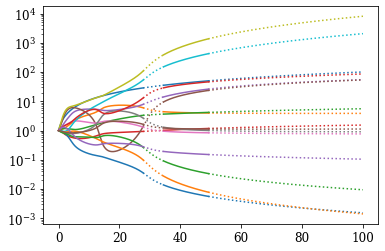

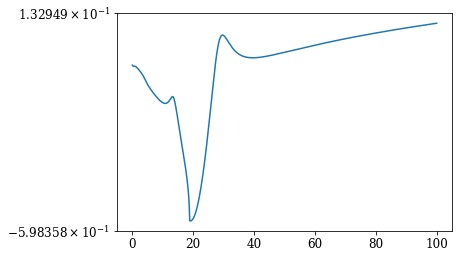

In [18]:
imp.reload(rmtchem)
n=8
nr=int(1.0*n*np.log(n))
nd=int(0.2*n)
na=int(0.5*nr)

n=16
nr=int(0.5*n*np.log(n))
nd=int(0.1*n)
na=int(0.0*nr)
seed=134
seed=3

np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr,na) 
row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_matrix(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]
d0=1e6
d1min=0
d1max=100
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
X0=np.exp(-G)
print(inds)

r=np.linalg.matrix_rank(adj.toarray()[np.ix_(lcc,lcc)])
if(r==n):

    Xs,epsilons,evals,bif=rmtchem.quasistatic(X0, eta, nu, k, XD1, XD2, d1min,d1max,0,dep0=1e-2,output=2, stop=False)
    print(len(Xs),bif)

inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i]/np.exp(-G[i]),color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i]/np.exp(-G[i]),ls=':',color=colors[np.mod(i,len(colors))])
plt.show()


plt.yscale('symlog')
plt.plot(epsilons,np.max(np.real(evals),axis=1))
plt.show()

49.5 18.59011869222145 (0.0003760690166121181+0.3379852173729596j)
0.013799	0.001329	20307	102	lsoda	
Found oscillating state!
True


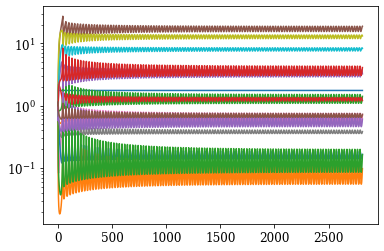

144


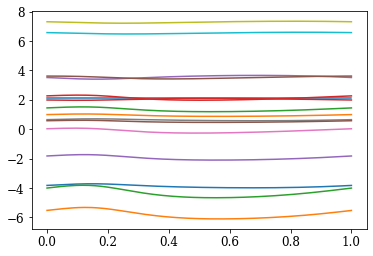

The algorithm converged to the desired accuracy. 287


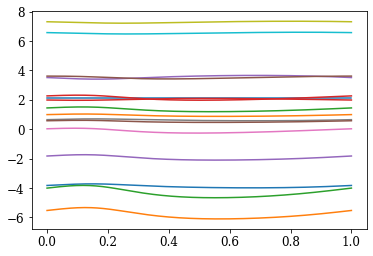

In [197]:
imp.reload(rmtchem)
m0=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
# epsilon=epsilons[m0]+1e-2
epsilon=49.5
# m0=np.where(np.max(np.real(evals),axis=1)>0)[0][-1]
# epsilon=epsilons[m0]-1e-1
period=2*np.pi/(np.imag(evals[m0,np.argmax(np.real(evals[m0]))]))
print(epsilon,period,evals[m0,np.argmax(np.real(evals[m0]))])
np.random.seed(1)
ts,Xts,success,m1,state=rmtchem.integrate(Xs[m0], eta, nu, k, (1+epsilon)*XD1,XD2,1e4*period,period/10000,output=True)
print(success)
plt.yscale('log')
plt.plot(ts,np.transpose(Xts)/Xs[m0])
plt.show()

minds=find_peaks(np.linalg.norm(Xts,axis=0))[0]
period=ts[minds[-2]]-ts[minds[-3]]

tinds=np.where(np.all([ts>ts[-1]-period],axis=0))[0]
period0=ts[tinds[-1]]-ts[tinds[0]]
print(len(tinds))
ts0=(ts[tinds]-ts[tinds[0]])/(ts[tinds[-1]]-ts[tinds[0]])
Xts0=Xts[:,tinds]
y0=np.log(Xts0)
plt.plot(ts0,np.transpose(y0))
plt.show()

sol0=solve_bvp(lambda ts,Yts,p: p[0]*np.transpose([np.exp(-Yts[:,i])*rmtchem.func(ts[i],np.exp(Yts[:,i]),eta,nu,k,(1+epsilon)*XD1,XD2) for i in range(len(ts))]), lambda xa,xb,p: (np.concatenate((xb-xa,[(xa@xa)-(y0[:,0]@y0[:,0])]))), ts0, y0, p=np.array([period0]), fun_jac=lambda ts,Yts,p: (p[0]*np.transpose([np.transpose(np.transpose(rmtchem.jac(ts[i],np.exp(Yts[:,i]),eta,nu,k,(1+epsilon)*XD1,XD2)*np.exp(Yts[:,i]))*np.exp(-Yts[:,i]))-np.diag(np.exp(-Yts[:,i])*rmtchem.func(ts[i],np.exp(Yts[:,i]),eta,nu,k,(1+epsilon)*XD1,XD2)) for i in range(len(ts))],(1,2,0)), np.transpose([[np.exp(-Yts[:,i])*rmtchem.func(ts[i],np.exp(Yts[:,i]),eta,nu,k,(1+epsilon)*XD1,XD2)] for i in range(len(ts))],[2,1,0])), bc_jac=lambda xa,xb,p: (np.concatenate((-np.identity(n),2*xa[np.newaxis,:]),axis=0),np.concatenate((np.identity(n),np.zeros(n)[np.newaxis,:]),axis=0),np.zeros((n+1,1))), max_nodes=10000,tol=1e-1,bc_tol=1e-2)
print(sol0.message,len(sol0.x))
plt.plot(sol0.x,np.transpose(sol0.y))
plt.show()

51.345000	1.000e-02	291	4.579321e+00	-1		f
 A singular Jacobian encountered when solving the collocation system.
51.610000	1.000e-02	293	4.895520e+00	-1	f
 A singular Jacobian encountered when solving the collocation system.
51.625000	5.000e-03	301	4.908928e+00	-1	f
 A singular Jacobian encountered when solving the collocation system.
51.640000	2.500e-03	311	4.904716e+00	-1	f
 A singular Jacobian encountered when solving the collocation system.
51.641250	1.250e-03	311	4.909615e+00	-1	f
 A singular Jacobian encountered when solving the collocation system.
f
 A singular Jacobian encountered when solving the collocation system.
f
 A singular Jacobian encountered when solving the collocation system.
f
 A singular Jacobian encountered when solving the collocation system.
f
 A singular Jacobian encountered when solving the collocation system.
f
 A singular Jacobian encountered when solving the collocation system.
f
 A singular Jacobian encountered when solving the collocation system.
f
 A si

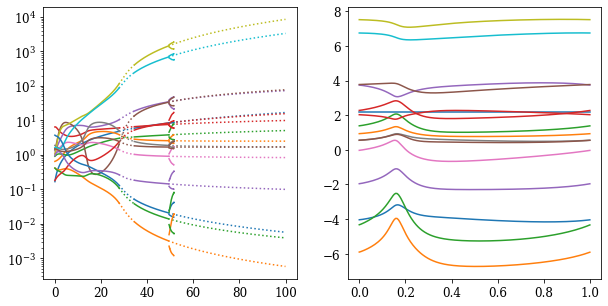

In [201]:
from IPython import display
m0=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
epsilon=epsilons[m0]+1e-2
epsilon=49.5
sols=[]
eps=[]
rolls=[]
sol=sol0
start=timeit.default_timer()
dm=1
dep=1e-3
depmax=1e-2
depmin=1e-6
epmax=34.43
epmax=80
np.seterr(all='ignore')
count=0

mean=np.sum(np.diff(sol.x)*np.linalg.norm(sol.y[:,:-1],axis=0))
mins=argrelmin(np.concatenate((np.abs(np.linalg.norm(sol.y,axis=0)-mean)[:-1],np.abs(np.linalg.norm(sol.y,axis=0)-mean))))[0]
roll=int(np.mod(mins[np.argmin(np.abs(np.mod(mins+len(sol.x)/2,len(sol.x))-len(sol.x)/2))]+len(sol.x)/2,len(sol.x))-len(sol.x)/2)
y0=np.roll(sol.y,-roll,axis=1)
x0=np.concatenate(([0],np.cumsum(np.roll(np.diff(sol.x),-roll))))
sol.x=x0
sol.y=y0

while sol.success and epsilon<epmax:
    #We should update the initial Xts with an estimate based on Jacobian and dep
    epsilon=epsilon+dep 
    sols.append(sol)
    eps.append(epsilon)
    mean=np.sum(np.diff(sol.x)*np.linalg.norm(sol.y[:,:-1],axis=0))
    mins=argrelmin(np.concatenate((np.abs(np.linalg.norm(sol.y,axis=0)-mean)[:-1],np.abs(np.linalg.norm(sol.y,axis=0)-mean))))[0]
    roll=int(np.mod(mins[np.argmin(np.abs(np.mod(mins+len(sol.x)/2,len(sol.x))-len(sol.x)/2))]+len(sol.x)/2,len(sol.x))-len(sol.x)/2)
    y0=np.roll(sol.y,-roll,axis=1)
    x0=np.concatenate(([0],np.cumsum(np.roll(np.diff(sol.x),-roll))))
    p0=sol.p[0]
    rolls.append(roll)
    #solve_bvp will only add collocation points, which can get out of control. We may need to try to coarsen occasionally.
    try:
        sol=solve_bvp(lambda ts,Yts,p: p[0]*np.transpose([np.exp(-Yts[:,i])*rmtchem.func(ts[i],np.exp(Yts[:,i]),eta,nu,k,(1+epsilon)*XD1,XD2) for i in range(len(ts))]), lambda xa,xb,p: (np.concatenate((xb-xa,[(xa@xa)-(y0[:,0]@y0[:,0])]))), x0, y0, p=np.array([p0]), fun_jac=lambda ts,Yts,p: (p[0]*np.transpose([np.transpose(np.transpose(rmtchem.jac(ts[i],np.exp(Yts[:,i]),eta,nu,k,(1+epsilon)*XD1,XD2)*np.exp(Yts[:,i]))*np.exp(-Yts[:,i]))-np.diag(np.exp(-Yts[:,i])*rmtchem.func(ts[i],np.exp(Yts[:,i]),eta,nu,k,(1+epsilon)*XD1,XD2)) for i in range(len(ts))],(1,2,0)), np.transpose([[np.exp(-Yts[:,i])*rmtchem.func(ts[i],np.exp(Yts[:,i]),eta,nu,k,(1+epsilon)*XD1,XD2)] for i in range(len(ts))],[2,1,0])), bc_jac=lambda xa,xb,p: (np.concatenate((-np.identity(n),2*xa[np.newaxis,:]),axis=0),np.concatenate((np.identity(n),np.zeros(n)[np.newaxis,:]),axis=0),np.zeros((n+1,1))), max_nodes=1000,tol=1e1,bc_tol=1e-2)
#         sol=solve_bvp(lambda ts,Yts,p: p[0]*np.transpose([np.exp(-Yts[:,i])*rmtchem.func(ts[i],np.exp(Yts[:,i]),eta,nu,k,(1+epsilon)*XD1,XD2) for i in range(len(ts))]), lambda xa,xb,p: (np.concatenate((xb-xa,[(xa@xa)-(y0[:,0]@y0[:,0])]))), x0, y0, p=np.array([p0]), fun_jac=lambda ts,Yts,p: (p[0]*np.transpose([np.transpose(np.transpose(rmtchem.jac(ts[i],np.exp(Yts[:,i]),eta,nu,k,(1+epsilon)*XD1,XD2)*np.exp(Yts[:,i]))*np.exp(-Yts[:,i]))-np.diag(np.exp(-Yts[:,i])*rmtchem.func(ts[i],np.exp(Yts[:,i]),eta,nu,k,(1+epsilon)*XD1,XD2)) for i in range(len(ts))],(1,2,0)), np.transpose([[np.exp(-Yts[:,i])*rmtchem.func(ts[i],np.exp(Yts[:,i]),eta,nu,k,(1+epsilon)*XD1,XD2)] for i in range(len(ts))],[2,1,0])), bc_jac=lambda xa,xb,p: (np.concatenate((-np.identity(n),2*xa[np.newaxis,:]),axis=0),np.concatenate((np.identity(n),np.zeros(n)[np.newaxis,:]),axis=0),np.zeros((n+1,1))), max_nodes=1000,tol=1e0,bc_tol=1e-2)
        if not sol.success:
            count=0
            print('f',end='')
            raise Exception(sol.message)
        count=count+1
        if len(sol.x)>1.25*len(sols[-1].x):
            print('m',end='')
            raise Exception('mesh increased too fast')
        if (np.abs(np.max(y0)-np.max(sol.y))/np.max(y0)>5e-1):
            print('c',end='')
            raise Exception('solution changed too much')
    except Exception as e:
        print('\n',str(e))
        epsilon=epsilon-dep
        dep=dep/2
        sol=sols[-1]
        if dep>depmin:
            continue
        else:
            print('\nstep size too small')
            break
            
    if count>10:
        dep=np.min([depmax,dep*2])
        count=0
    print('\r%f\t%.3e\t%i\t%e\t%i\t'%(epsilon, dep,len(sol.x),sol.p[0]-period,roll),end='')

    
stop=timeit.default_timer()
print('\n',sol.message,len(sols),len(sols[0].x),len(sols[-1].x),stop-start)


fig,ax=plt.subplots(1,2,figsize=(10,5))

inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
ax[0].set_yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        ax[0].plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        ax[0].plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])
for i in range(n):
    ax[0].plot(eps,[np.exp(np.max(sols[j].y[i])) for j in range(len(sols))],color=colors[np.mod(i,len(colors))])
    ax[0].plot(eps,[np.exp(np.min(sols[j].y[i])) for j in range(len(sols))],color=colors[np.mod(i,len(colors))])

ax[1].clear()
ax[1].plot(sol.x,np.transpose(sol.y))
plt.show()

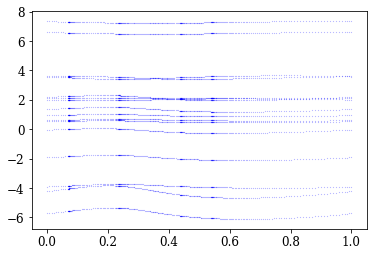

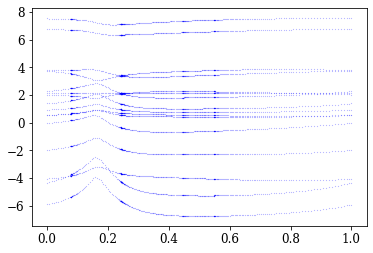

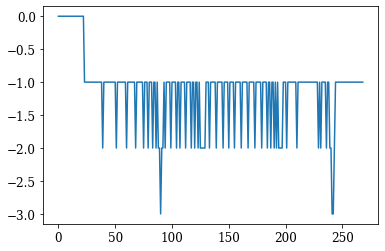

In [204]:
#We need to move the mesh with the peaks rather than with the boundary condition it seems. Maybe we should center the peak in norm rather than the mean
#Alternatively, updating the initial guess with the Jacobian may help
plt.plot(sols[1].x,np.transpose(sols[1].y),'bo',markersize=0.1)
plt.show()
plt.plot(sols[-1].x,np.transpose(sols[-1].y),'bo',markersize=0.1)
plt.show()
plt.plot(rolls)
plt.show()

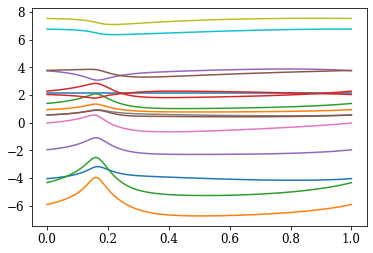

In [206]:
plt.plot(sol.x,np.transpose(sol.y))
plt.show()

A singular Jacobian encountered when solving the collocation system. False


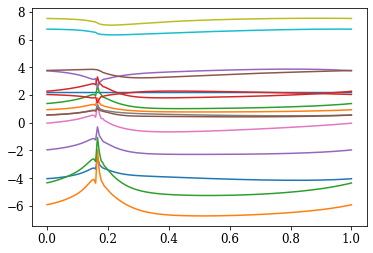

In [213]:
sol=solve_bvp(lambda ts,Yts,p: p[0]*np.transpose([np.exp(-Yts[:,i])*rmtchem.func(ts[i],np.exp(Yts[:,i]),eta,nu,k,(1+epsilon)*XD1,XD2) for i in range(len(ts))]), lambda xa,xb,p: (np.concatenate((xb-xa,[(xa@xa)-(y0[:,0]@y0[:,0])]))), x0, y0, p=np.array([p0]), fun_jac=lambda ts,Yts,p: (p[0]*np.transpose([np.transpose(np.transpose(rmtchem.jac(ts[i],np.exp(Yts[:,i]),eta,nu,k,(1+epsilon)*XD1,XD2)*np.exp(Yts[:,i]))*np.exp(-Yts[:,i]))-np.diag(np.exp(-Yts[:,i])*rmtchem.func(ts[i],np.exp(Yts[:,i]),eta,nu,k,(1+epsilon)*XD1,XD2)) for i in range(len(ts))],(1,2,0)), np.transpose([[np.exp(-Yts[:,i])*rmtchem.func(ts[i],np.exp(Yts[:,i]),eta,nu,k,(1+epsilon)*XD1,XD2)] for i in range(len(ts))],[2,1,0])), bc_jac=lambda xa,xb,p: (np.concatenate((-np.identity(n),2*xa[np.newaxis,:]),axis=0),np.concatenate((np.identity(n),np.zeros(n)[np.newaxis,:]),axis=0),np.zeros((n+1,1))), max_nodes=1000,tol=1e1,bc_tol=1e-2)
print(sol.message,sol.success)
plt.plot(sol.x,np.transpose(sol.y))
plt.show()

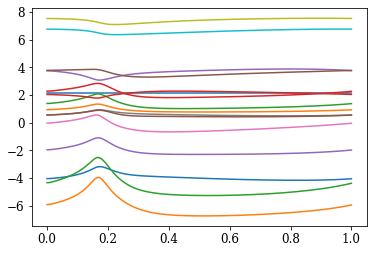

In [216]:
plt.plot(x0,np.transpose(y0))
plt.show()

In [264]:
imp.reload(rmtchem)
def hess(t,X,eta,nu,k,XD1,XD2):
    return np.tensordot(eta-nu,rmtchem.rates(X,eta,nu,k)[:,np.newaxis,np.newaxis]*(nu[:,:,np.newaxis]*nu[:,np.newaxis,:]-nu[:,:,np.newaxis]*np.identity(len(X))[np.newaxis,:,:])/(X[np.newaxis,:,np.newaxis]*X[np.newaxis,np.newaxis,:]), axes=(0,0)) 
    
v1=np.zeros(len(X0))
v2=np.zeros(len(X0))
v3=np.zeros(len(X0))
i=0
j=1
k=2
v1[i]=1
v2[j]=1
v3[k]=1
start=timeit.default_timer()
h1=hess(0,X0,eta,nu,k,XD1,XD2)
stop=timeit.default_timer()
print(stop-start)
start=timeit.default_timer()
h2=rmtchem.hess(0,X0,eta,nu,k,XD1,XD2)
stop=timeit.default_timer()
start=timeit.default_timer()
t2=rmtchem.third(0,X0,eta,nu,k,XD1,XD2)
stop=timeit.default_timer()
print(stop-start)
print(np.linalg.norm(h1-h2))

0.00039005299913696945
0.003623595002864022
0.0
